In [3]:
# To support both python 2 and python 3# To su 
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
### Import MNIST data set for classifcation excercises

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
# analyse data set
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

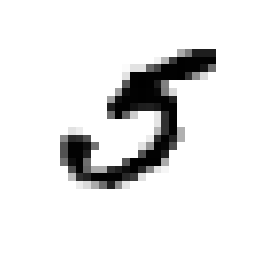

In [11]:
# draw a random entry 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap =matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [13]:
# check label
y[36000]

5.0

In [14]:
# creat train and test data set
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#shuffle data set to improve cross-validation results (current set is sortet by digit)
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [30]:
#train binary classificator for classifying 5 against none 5, set "5" to be true vs. everything else to false
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [31]:
y_train_5

array([False, False, False, ..., False, False, False])

In [40]:
### fitting a stochastic gradient classifier (SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=10, tol=None, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       epsilon=0.10000000000000001, eta0=0.0, fit_intercept=True,
       l1_ratio=0.14999999999999999, learning_rate='optimal', loss='hinge',
       max_iter=10, n_iter=None, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [41]:
#result shows true for predicting a 5, which is correct
sgd_clf.predict([some_digit])

array([ True])

In [42]:
### checking quality measures for trained model

#implement cross validation without using cross_val_score for more control

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42) #creating 3 folds with fixed random state

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9486
0.9654
0.957


In [43]:
#doing the same cross validation using cross_val_score

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9486, 0.9654, 0.957 ])